> # ***Quora Insincere Questions Classification***

#### BÁO CÁO ĐỀ TÀI CUỐI KỲ  
   **Họ và tên**: Lê Tiến Phát  
   **MSSV**: 18020993  
   **Lớp học phần**: INT_3405_1  
   **Giảng viên**: Trần Quốc Long  

# **1. Mô tả bài toán**

[Quora](https://www.quora.com) là một diễn đàn mở với mục đích trao đổi kiến thức giữa người với người. Trên diễn đàn mọi người sẽ đưa ra những thắc mắc và nhận lại những câu trả lời mang tính chuyên sâu và chất lượng. Vấn đề cần giải quyết lúc này là tìm và loại bỏ những câu hỏi thiếu thành thật hay thiếu tế nhị (insincere) mang tính phát biểu thể hiện hơn là cần tìm kiếm câu trả lời. 

* **Input:** Câu hỏi bằng tiếng Anh
* **Output:** Xác nhận TRUE/FALSE rằng câu hỏi có insincere hay không, bằng cách đánh label 0 cho *sincere* và 1 cho *insincere* 

# **2. Phân tích dữ liệu** 

In [ ]:
# Khởi tạo môi trường
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import os
import time
import matplotlib.pyplot as plt
import gc

from sklearn.model_selection import train_test_split
from sklearn import metrics

from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string

from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, GlobalMaxPool1D, Input, Embedding, Dropout, Dense, CuDNNLSTM, BatchNormalization,SpatialDropout1D 
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

import zipfile
from gensim.models.keyedvectors import KeyedVectors

Một câu hỏi cho là *insincere* khi có các yếu tố:  
* Tông giọng khác biệt: 
 * Phóng đại, khoa trương về một góc nhìn hay phát biểu hướng tới một nhóm người nhất định  
* Có tính miệt thị hay kích động:  
 * Phân biệt đối xử hay miệt thị với một nhóm người một cá nhân hoặc một đám người  
 * Miệt thị một tính cách hay tính chất khác thường  
* Không đúng sự thật: thông tin sai / giả định vô lý  
* Chứa quan hệ tình dục để gây sốc  

## 2.1. Các tập dữ liệu

In [ ]:
# Load dữ liệu từ file csv
train_df = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/train.csv")
test_df = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/test.csv")

Dứ liệu đầu vào gồm 2 tệp `train.csv` và `test.csv`.  

* Tệp `train`: Gồm 1306122 dòng và 3 cột (`qid`, `question_text`, `target`)

In [ ]:
print("Kích thước bảng file 'train':", train_df.shape)
print("Mẫu dữ liệu file 'train':")
train_df.head()

* Tệp `test`: Gồm 375806 dòng và 2 cột (`qid`, `question_text`)

In [ ]:
print("Kích thước bảng file 'test':", test_df.shape)
print("Mẫu dữ liệu file 'test':")
test_df.head()

Ngoài ra còn chứa tệp nén `embeddings.zip` chứa danh sách các từ đã vector hóa có thể được dùng trong model  

## 2.2. Phân tích dữ liệu

Có 3 trường cần phải xử lý:  
* **Trường `qid`**: là ID đặc trưng cho từng câu hỏi, không tồn tại 2 câu hỏi nào trùng ID.  
* **Trường `question_text`**: là các câu hỏi bằng tiếng Anh, cần được xử lý trước khi đưa vào model.  
* **Trường `target`**: là label kết quả được đánh giá, 0/1 tương ứng với *sincere/insincere*.

#### **Kiểm tra phân bố tập dữ liệu theo `target`:** 

In [ ]:
# Lấy số câu hỏi, số câu sincere/insincere
sincere_qt = train_df[train_df.target == 0]
insincere_qt = train_df[train_df.target == 1]

print("Số câu hỏi: ", train_df.shape[0])
print("Sincere: ", sincere_qt.shape[0])
print("Insincere: ", insincere_qt.shape[0])

# Biểu diễn qua đồ thị hình tròn
label = 'Sincere', 'Insincere'
size = [(sincere_qt.shape[0] / train_df.shape[0]) * 100, (insincere_qt.shape[0] / train_df.shape[0]) * 100]
plt.pie(size, labels = label, colors=["c", "y"], autopct="%.2f%%")
plt.show()


Phân bố trong tập `train` cho thấy tỉ lệ thấp câu hỏi được đánh nhãn *insincere* hay tập dữ liệu rất mất cân bằng, dẫn đến những vấn đề như mô hình hoạt động kếm hiệu quả với những trường hợp `target` = 1, hay metric accuracy không thể hiện rõ chất lượng mô hình.

=> Cần sử dụng metric thay thế như *F1_score* 

#### **Kiểm tra các từ trong `question_text`**: 

In [ ]:
# Kiểm tra tệp train
print('Số từ trung bình mỗi câu hỏi: {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Số từ tối đa trong câu hỏi: {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Số ký tự trung bình mỗi câu hỏi: {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x)))))

# Phân bố độ dài `question_text` theo số từ
plt.figure(figsize=(16,5))
plt.hist(train_df['question_text'].apply(lambda x: len(x.split())), bins=60)
plt.yscale('log')
plt.xlabel('Số từ/câu')
plt.title('Phân bố độ dài `question_text` theo số từ')
plt.xticks(range(0,140,5))
plt.show()

* Các câu hỏi trong tệp `train` có độ dài trung bình không quá lớn, phần lớn dưới 70 từ, nhưng cũng có một số câu khá dài. 

* Tần xuất các từ trong tệp `train` tương ứng với `target`:  
 * Cần loại bỏ đi các từ lặp lại nhiều nhưng ít tác động đến đánh giá *sincere/insincere* (gọi là stop-word, được thêm vào bằng bộ công cụ ngôn ngữ tự nhiên NLTK), gây cản trở và làm giảm tốc độ xử lý. 

In [ ]:
from collections import defaultdict

# Thiết lập stop-words
stop_words = set(stopwords.words('english'))

# Tạo dictionary để đếm từ
sin_freq_dict = defaultdict(int)
ins_freq_dict = defaultdict(int)

# Hàm tách câu thành từ, loại bỏ stop-words 
def tokens(text):
    tokens = [token for token in text.lower().split(" ") if token != "" if token not in stop_words]
    return tokens

# Đếm từ
for qt in sincere_qt["question_text"]:
    for word in tokens(qt):
        sin_freq_dict[word] += 1
sfd_sorted = pd.DataFrame(sorted(sin_freq_dict.items(), key=lambda x: x[1], reverse=True)[::-1])
sfd_sorted.columns = ["word", "frequency"]

for qt in insincere_qt["question_text"]:
    for word in tokens(qt):
        ins_freq_dict[word] += 1
ifd_sorted = pd.DataFrame(sorted(ins_freq_dict.items(), key=lambda x: x[1], reverse=True)[::-1])
ifd_sorted.columns = ["word", "frequency"]

# Biểu diễn bằng đồ thị
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

sfd_sorted.tail(20).plot(x= 'word', kind = "barh", title="Top 20 từ trong câu hỏi label 'sincere'", ax=ax1)
ifd_sorted.tail(20).plot(x= 'word', kind = "barh", title="Top 20 từ trong câu hỏi label 'insincere'", ax=ax2)

* Các từ trong các câu có nhãn `sincere` thường là các từ chung chung và thông dụng, trong khi đó các từ trong câu có nhãn `insincere` thường có xu hướng nhắm vào các đối tượng, lĩnh vực riêng như chủng tộc, tôn giáo hay giới tính

## 2.3. Tối ưu dữ liệu

**Các bước tiền xử lý dữ liệu `question_text` bao gồm:**
* Chuyển về unicode và chữ thường để loại bỏ các ký tự đặc biệt
* Loại bỏ các ký tự (punctuation), chữ số do không nhiều tác dụng trong việc huấn luyện model
* Tách rời từng câu thành các mảng chứa từ (tokens)
* Rút gọn từ loại (đưa các từ cùng dạng về thành 1 từ, như các động từ từ các dạng về nguyên thể, hay các từ cùng ngữ pháp sẽ đưa về từ loại gốc - [Stemming / Lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html))
* Loại bỏ stop-words (các từ lặp lại nhiều nhưng ít tác động đến đánh giá, gây cản trở và làm giảm tốc độ xử lý)  
##### => Thu gọn dữ liệu `question_text` trở thành các chuỗi gồm các từ khóa mang gần như toàn bộ ý nghĩa của câu   

In [ ]:
# Tách file `train` thành 2 phần `train` và `validate` để huấn luyện
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=40)

# Tách đầu vào 'question_text' từ file 'train'
train_X = train_df["question_text"]
val_X = val_df["question_text"]
test_X = test_df["question_text"]

# Tách đầu ra 'target' từ file 'train'
train_y = train_df['target'].values
val_y = val_df['target'].values

# Load model rút gọn từ loại
lemmatizer = WordNetLemmatizer();

# Hàm xử lý các chuỗi 'question text' thành các mảng chứa từ 
def clean_qt(question_text):
    q_text = str(unidecode(question_text.lower()).encode("ascii"),"ascii")           # Chuyển về unicode và chữ thường
    q_text = q_text.translate(str.maketrans('', '', string.punctuation + string.digits)) # Loại bỏ ký tự và chữ số
    q_tokens = text_to_word_sequence(q_text)                                         # Tách từng câu thành mảng chứa từ
    q_tokens_simplify = [lemmatizer.lemmatize(token) for token in q_tokens]          # Rút gọn từ loại
    q_tokens_min = [token for token in q_tokens_simplify if token not in stop_words] # Loại bỏ stop-word
    return q_tokens_min
    
train_X = train_X.apply(clean_qt)
val_X = val_X.apply(clean_qt)
test_X = test_X.apply(clean_qt)

In [ ]:
# Test kết quả
print(train_df["question_text"].head(5), "\n", train_X[0:5])

## 2.4. Biến đổi dữ liệu huấn luyện  

Để việc huấn luyện đạt hiệu quả, ta cần phải đưa dữ liệu từ các từ khóa thành dạng mà máy tính có thể hiểu.  
Các quá trình biến đổi dữ liệu báo gồm:
  * **Mã hóa từ**: gồm việc thay thế từ bằng một ID là số tự nhiên và ghi lại từ điển đối chiếu giữa từ và ID, mảng từ sẽ thay bằng chuỗi số. Việc này có tác dụng thống kê số từ đặc trưng (có bao nhiêu từ, từ nào xuất hiện nhiều, ...) và giảm bộ nhớ khi các từ xuất hiện nhiều thì sẽ biểu diễn bởi số nhỏ
  * **Cân bằng chuỗi**: là việc kéo dài chuỗi lên độ dài MAX_LEN là 70 với những chuỗi ngắn hơn và bổ sung vào chuỗi là những ID 0, hoặc cắt ngắn chuỗi dài hơn về 70 (Do như thống kê phía trên, đa phần độ dài câu khi chưa tối ưu thường dài dưới 70 từ). Cân bằng chuỗi giúp huấn luyện tốt hơn do độ dài input là như nhau


In [ ]:
# Thiết lập các hắng số
EMBED_SIZE = 300 # Kích thước hay số chiều của vector từ
MAX_FEATURES  = 100000 # Số lượng từ đặc trưng tối đa, hay số lượng vector tôi đa 
MAX_LEN = 70 # Số lượng từ tối đa trong một câu

# Lập từ điển mã hóa từ thành các ID
tokenizer = Tokenizer(filters='', num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_X)

# Chuyển các chuỗi từ thành chuỗi ID
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

# Cân bằng đọ dài chuỗi bằng với MAX_LEN  
train_X = pad_sequences(train_X, maxlen=MAX_LEN)
val_X = pad_sequences(val_X, maxlen=MAX_LEN)
test_X = pad_sequences(test_X, maxlen=MAX_LEN)

   * **Vector hóa từ**: là việc thay thể từ bằng một vector số thực nhiều chiều, nói cách khác là mã hóa biểu diễn từ lên không gian đa chiều, với mục đích giúp máy tính hiểu được ý nghĩa của từ theo cách các từ đồng nghĩa, gần nghĩa sẽ có biểu diễn vector gần giống nhau. Đông thời việc sử dụng các model pretrained giúp tăng độ chuẩn xác cũng như giảm thời gian xử lý.  
  
Ở đây ta dùng pretrained weights cung cấp bởi Google ([Word2Vec](https://code.google.com/archive/p/word2vec)) và Stanford NLP ([GloVe](https://nlp.stanford.edu/projects/glove/)), kết hợp từ điển word - ID tạo ở phía trên có thể tạo ra ma trận liên hệ giữa ID - vector, đưa vào model

In [ ]:
# Load pre-trained weights từ tệp nén chứa các từ và vector tương ứng  
archive = zipfile.ZipFile('../input/quora-insincere-questions-classification/embeddings.zip', 'r')

# Hàm chuyển weights pretrained cho vector từ thành weights cho model 
def loadEmbeddingMatrix(typeToLoad): # typetoLoad = 'glove' | 'word2vec' 
    # GloVe
    embeddings_index = dict()
    if (typeToLoad == "glove"):
        # Load file
        EMB_FILE =  archive.open('glove.840B.300d/glove.840B.300d.txt')
        # Chuyển weights thành từ điển qua việc đọc từng dòng trong file
        for embd in EMB_FILE:
            # Ngắt dòng thành mảng
            word2vec = embd.decode().split(' ')
            # Vị trí đầu tiên trong mảng là từ
            word = word2vec[0]
            # Tạo mảng chứa các vị trí còn lại thành vector tương ứng với từ
            embeddings_index[word] = np.asarray(word2vec[1:EMBED_SIZE+1], dtype='float32')
        EMB_FILE.close()
        gc.collect()
        print('GloVe - Loaded %s vector từ.' % len(embeddings_index))
        
    # Google Word2vec 
    elif (typeToLoad == "word2vec"):
        # Load file 
        EMB_FILE =  archive.open('GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin')
        # Chuyển thành từ điển bằng module được implement sẵn  
        emb_google_word2vec = KeyedVectors.load_word2vec_format(EMB_FILE, binary=True, limit=1000000)
        for word in emb_google_word2vec.index_to_key:
                embeddings_index[word] = emb_google_word2vec.get_vector(word)
        EMB_FILE.close()
        gc.collect()
        print('Word2Vec - Loaded %s vector từ.' % len(embeddings_index))
    
    # Tạo ma trận kích thước (số từ x kích thước vector) hay (MAX_FEATURES x EMBED_SIZE)
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    nb_words = min(MAX_FEATURES, len(tokenizer.word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, EMBED_SIZE))
    
    # Nhập từng vector tương ứng với word ID
    embeddedCount = 0
    for word, i in tokenizer.word_index.items():
        if i >= MAX_FEATURES: continue
        # Load vector 
        embedding_vector = embeddings_index.get(word)
        # Lưu vào ma trận
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            embeddedCount+=1
    print('Nhập vào %d vector' % embeddedCount)
    
    del(embeddings_index)
    gc.collect()
    
    return embedding_matrix

emb_glove_matrix = loadEmbeddingMatrix("glove")
emb_google_matrix = loadEmbeddingMatrix("word2vec")
# Gộp 2 ma trận để tăng hiệu quả
embd_total_matrix = np.mean([emb_glove_matrix, emb_google_matrix], axis = 0)

# **3. Huấn luyện**

## 3.1. Kiến trúc của mô hình

  Mô hình mạng **RNN** (Recurrent Neural Network) được sử dụng nhiều ở các bài toán xử lý ngôn ngữ, do việc xử lý thông tin dưới dạng chuỗi hiệu quả vì ngoài đầu vào thông thường của một mạng neural, trạng thái ẩn bước trước cũng được thêm vào thành đầu vào bước sau. Trong bài này sẽ sử dụng mô hình phát triển dựa trên RNN là mạng **LTSM 2 chiều** (Bi-directional LSTM).  
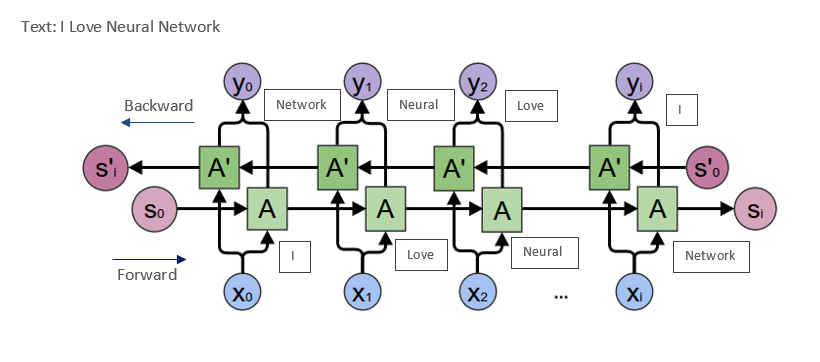
  Mạng LTSM sinh ra để khắc phục việc mạng RNN không học được từ chuỗi quá dài do triệt tiêu đạo hàm bằng cách thêm một biến trạng thái ô cùng với trạng thái ẩn làm đầu vào bước sau, những thông tin cần lưu trữ sẽ được cập nhật qua trạng thái ô. Khi dùng mạng LTSM 2 chiều, thông tin lưu trữ được không chỉ ở các bước quá khứ mà còn có cả các bước tương lai, làm tăng tính hiệu quả vì dự đoán cần cả ngữ cảnh phía trước và sau.  
  
  Cấu trúc mạng bao gồm:
* Lớp Embedding là bộ pre-trained embedding được tính toán phía trên. Đầu ra có sử dụng Dropout để tránh overfit.  
* Lớp LSTM với 2 tầng và mỗi tầng 128 units.   
* Mạng MLP với hàm kích hoạt là ReLU, có sử dụng Batchnorm và Dropout, cuối cùng là 1 lớp hàm sigmoid.  

In [ ]:
model = Sequential()

model.add(Input(shape=(MAX_LEN,)))
# Lớp Embedding
model.add(Embedding(MAX_FEATURES, EMBED_SIZE, weights=[embd_total_matrix]))
model.add(SpatialDropout1D(0.5)) 

# Lớp Bi-directional LTSM
model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True)))
model.add(GlobalMaxPool1D())

# Mạng MLP
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1, activation="sigmoid"))

# Model hoàn chỉnh
model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])
print(model.summary())

## 3.2. Huấn luyện và đánh giá
Huấn luyện với hàm loss là **binary cross entropy**, hàm tối ưu là **Adam**.

In [ ]:
# Thực hiện train
# Tạo chekpoint
file_path = "model_b128_val0.2_e10.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1, save_best_only = False, mode = "min")

# Huấn luyện và ghi lại thống kê
history = model.fit(train_X, train_y, batch_size=128, epochs=10, validation_data=(val_X, val_y)) #, callbacks=[check_point])

#### Model loss qua mỗi epoch:

In [ ]:
# Đồ thì model loss
epochRange = np.arange(1,11,1)
plt.plot(epochRange, history.history['loss'])
plt.plot(epochRange, history.history['val_loss'])
plt.xticks(np.arange(1,11,1))
plt.yticks(np.arange(0,0.5,0.05))
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

#### Đánh giá F1_score

Bình thường ở các mô hình phân lớp nhị phân kết quả dự đoán luôn thuộc đoạn (0,1) với ngưỡng (threshold) là 0.5, tức là nếu kết quả dưới ngưỡng 0.5 thì phân lớp là 0, ngược lại thì là 1.

Nhưng trong một số trường hợp, giá trị ngưỡng 0.5 này có thể không phải là tốt nhất. Trong bài toán này cần chọn threshold sao cho F1_score là cao nhất, làm tăng tỉ lệ dự đoán 

In [ ]:
pred_train_y = model.predict([train_X], batch_size=128, verbose=1)
threshs = np.arange(0.1, 0.5, 0.01, dtype=float)
f1 = np.zeros_like(threshs, dtype=float)
i = 0
for thresh in threshs:
    f1[i]=(metrics.f1_score(train_y, (pred_train_y>thresh).astype(int)))
    i+=1
plt.plot(threshs, f1)

In [ ]:
f1_max = np.amax(f1)
index = np.where(f1==f1_max)
thresh_f1_max = threshs[index]

print('F1-score tối đa là %.2f tại ngưỡng %.2f' % (f1_max, thresh_f1_max))

## 4. Áp dụng 

In [ ]:
pred_test_y = model.predict([test_X], batch_size=256, verbose=1)
pred_test_y = np.where(pred_test_y>thresh_f1_max,1,0)                                
out_df = pd.DataFrame({"qid":test_df["qid"].values})
out_df['prediction'] = pred_test_y
out_df.to_csv("submission.csv", index=False)